In [2]:
import json
import time
import torch
import numpy as np
import pandas as pd
import dask.dataframe as dd
from PIL import Image
from dask.distributed import Client
from cerebro.dask_backend import DaskBackend
from cerebro.dataset_info import DatasetInfo
from cerebro.params import Params
from cerebro.etl import etl
import cerebro.constants as constants
from torchvision import transforms
from sentence_transformers import SentenceTransformer, util

import matplotlib
from distributed.diagnostics import MemorySampler
from dask.distributed import performance_report

def prepare_data():
    data = None
    with open("/mydata/coco/annotations/captions_val2014.json") as f:
        data = json.load(f)
    dataset = {
        'id': [],
        'file_name': [],
        'height': [],
        'width': [],
        'captions': [],
        'date_captured': [] 
    }

    annotations = {}
    annotations_list = data['annotations']
    for i in annotations_list:
        if not i["image_id"] in annotations:
            annotations[i["image_id"]] = []
        annotations[i["image_id"]].append(i["caption"])

    for i in range(len(data['images'])):
        dataset['id'].append(data["images"][i]['id'])
        dataset['file_name'].append(data["images"][i]['file_name'])
        dataset['height'].append(data["images"][i]['height'])
        dataset['width'].append(data["images"][i]['width'])
        dataset['captions'].append(annotations[data["images"][i]['id']])
        dataset['date_captured'].append(data["images"][i]['date_captured'])

    dataset = pd.DataFrame(dataset)
    dataset.to_csv("/mydata/coco/annotations/captions_val2014_modified.csv", index=False)

def row_preprocessing_routine(row, to_root_path, kwargs):
    t1 = time.time()
    input_image_path = to_root_path + str(row["file_name"])
    output_caption = row["captions"]
    img = Image.open(input_image_path)
    img_tensor = transforms.PILToTensor()(img)
    enc_model = kwargs['nlp_model']
    caption_tensor = enc_model.encode([output_caption], convert_to_tensor=True)
    saved = [img_tensor, caption_tensor]
    t2 = time.time()
    return [ kwargs["io_time"], t2-t1]
    
def testing():
    prepare_data()
    df = pd.read_csv("/mydata/coco/annotations/captions_val2014_modified.csv")
    df.head()

In [3]:
dsk_bknd = DaskBackend("0.0.0.0:8786")

prepare_data()
is_feature_download = [False, True, False, False, False, False]
feature_names = ["id", "file_name", "height", "width", "captions", "date_captured"]
dtypes = (int, str, int, int, list, str)
data_info = DatasetInfo(feature_names, feature_names, [], dtypes, is_feature_download)

metadata_path = "/mydata/coco/annotations/captions_val2014_modified.csv"
from_root_path = "/mydata/coco/images/val2014/"
to_root_path = "/mydata/coco/val2014/"
output_path = ""
requirements_path = ""
download_type = constants.DOWNLOAD_FROM_SERVER
username = "vik1497"
host = "128.110.218.13"
pem_path = "/users/vik1497/cloudlab.pem"

nlp_model = SentenceTransformer('all-MiniLM-L6-v2')

params = Params(metadata_path, from_root_path, to_root_path,
    output_path, requirements_path, username, host, pem_path,
    download_type)

e = etl(dsk_bknd, params, row_preprocessing_routine, data_info)

e.load_data(frac=1)
e.shuffle_shard_data()
e.sharded_df.compute()
print(len(e.sharded_df))
result = e.preprocess_data(nlp_model=nlp_model)

Client dashboard:  http://0.0.0.0:8787/status
Number of workers: 2
40504


In [ ]:
with performance_report(filename="./benchmarking/report_3_workers.html"):
    out = result.compute()

In [ ]:
out1 = out.copy().to_frame()
out1[["io", "cpu"]] = list(out1["transformed_data"])
out1 = out1.drop("transformed_data", axis=1)
out1.head()

In [ ]:
io_sum = out1["io"].sum()
cpu_sum = out1["cpu"].sum()

In [ ]:
with open("./benchmarking/timings.csv", "a") as f:
    f.write(",".join(["3", str(io_sum), str(cpu_sum)]))
    f.write("\n")

<AxesSubplot:xlabel='time', ylabel='Cluster memory (GiB)'>

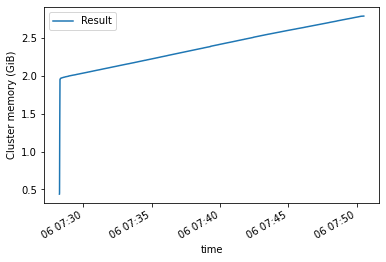

In [4]:
ms = MemorySampler()
with ms.sample("Result"):
    out = result.compute()
    
out_df = out.to_frame()
ms.plot()